# I. Linear least squares approximation

Consider a function $y = f(x)$ which is defined by a set of values $y_0, y_1, \cdots, y_n$ at points $x_0, x_1, \cdots, x_n$.

In [9]:
x = [-1, -0.7, -0.43, -0.14, -0.14, 0.43, 0.71, 1, 1.29, 1.57, 1.86, 2.14, 2.43, 2.71, 3]
y = [-2.25, -0.77, 0.21, 0.44, 0.64, 0.03, -0.22, -0.84, -1.2, -1.03, -0.37, 0.61, 2.67, 5.04, 8.90]

x = np.array(x)
y = np.array(y)

### I.I. Find a best fit polynomial

$$
P_m(x) = a_0 + a_1 x + \cdots + a_m x^m
$$

using the linear least squares approach. To this end

1. implement a function which constructs the design matrix using $1, x, \cdots, x^m$ as the basis functions.

2. construct explicitly the normal system of equations of the linear least squares problem at fixed $m$.

3. Solve the normal equations to find the coefficients of $P_m(x)$ for $m = 0, 1, 2, \dots$. For the linear algebra problem, you can either use library functions (`numpy.linalg.solve`) or your LU factorization code from week 1.

(20% of the total grade)

In [10]:
import numpy as np

def design_matrix(x, m):
    x = np.array(x)
    """Construct the design matrix with monomials x**k for k=0..m-1"""
    X = np.concatenate(
        [x.reshape(-1, 1) ** k for k in range(m)], 1
        )
    return X

assert design_matrix(x, 3).shape == (len(x), 3)
assert design_matrix(x, 11).shape == (len(x), 11)

def lsq_poly(x, y, m):
    """Construct the LSQ polynomial of degree `m-1`.
    
    Parameters
    ----------
    x : array_like
        Sample points
    y : array_like
        Measured values
    m : int
        The number of coefficients of the LSQ polynomial
        (i.e. the degree of the polynomial is `m-1`)
        
    Returns
    -------
    p : callable 
        np.polynomial.Polynomial instance, representing the LSQ polynomial
        
    Examples
    --------
    >>> p = lsq_poly([1, 2, 3], [4, 5, 6], m=2)
    >>> p(np.array([1.5, 2.5]))
    array([4.5, 5.5])
    
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if x.shape[0] != y.shape[0]:
        raise ValueError("Expect paired data.")
    if x.shape[0] <= m:
        raise ValueError("Cannot fit a degree-%s polynomial through %s points" % (m, x.shape[0]))
    
    X = design_matrix(x, m)
    A = X.T @ X
    b = X.T @ y
    w = np.linalg.solve(A, b)
    p = np.polynomial.Polynomial(w)
    return p

import pytest
with pytest.raises(ValueError):
    lsq_poly([1, 2, 3], [1, 2], m=1)

with pytest.raises(ValueError):
    lsq_poly([1, 2, 3], [1, 2, 3], m=3)
    
# test that lsq_poly returns a callable object
# which support vectorized evaluation
x = np.array(x)
p = lsq_poly(x, y, m=3)
assert len(p(x)) == len(x)

### I.II 

To find the optimal value of m, use the following criterion: take $m=0, 1, 2, \dots$, for each value of $m$ compute 

$$
\sigma_m^2 = \frac{1}{n - m} \sum_{k=0}^n \left( P_m(x_k) - y_k \right)^2
$$

And take the value of $m$, at which $\sigma_m$ stabilizes or starts increasing.

(20% of the total grade)

1 8.03076380952381
2 4.792540164145144
3 2.657879247377443
4 0.013604617199707248
5 0.01370644834186105
6 0.014000065867033958
7 0.01303966541318231
8 0.014044619150213327
9 0.01349760011218795
10 0.01551725421824213
11 0.017822399490496316
12 0.0071725436064177415
13 0.010693579414707173
14 0.02011296818085929


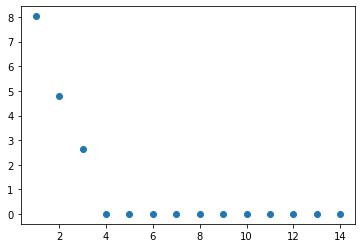

In [13]:
def sigma(x, y, m):
    r"""Compute $\sigma_m$."""
    p = lsq_poly(x, y, m)
    n = y.shape[0]
    return np.sum((p(x) - y) ** 2) / (n - m)

import matplotlib.pyplot as plt

for m in range(1, 15):
    print(m, sigma(x, y, m))

plt.scatter(range(1, 15), [sigma(x, y, m) for m in range(1, 15)]);

Plot your polynomials $P_m(x)$ on one plot, together with the datapoints. Visually compare best-fit polynomials of different degrees. Is the visual comparison consistent with the optimal value of $m$?

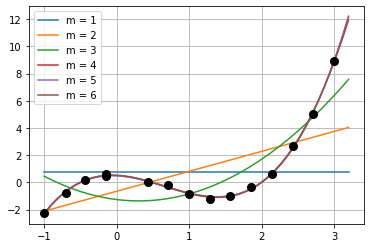

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for m in range(1, 7):
    p = lsq_poly(x, y, m)
    
    xx = np.linspace(-1, 3.2, 51)
    ax.plot(xx, p(xx), '-', label='m = %s' % m)

ax.plot(x, y, 'o', ms=8, color='k')
plt.legend(loc='best')
plt.grid()

### I.III. Linear least-squares using the QR factorization.

For the optimal value of $m$ from the previous part, solve the LLS problem using the QR factorization, withou ever forming the normal equations explicitly. For linear algebra, you can use standard library functions (look up `numpy.linalg.solve`, `numpy.linalg.qr` etc) or your code from previous weeks.

Compare the results with the results of solving the normal system of equations.

(20% of the grade)

In [14]:
import scipy.linalg

def lsq_qr(x, y, m):
    """Solve the LSQ problem via the QR decomp of the design matrix.

    Parameters
    ----------
    x : array_like
        Sample points
    y : array_like
        Measured values
    m : int
        The degree of the LSQ polynomial
        
    Returns
    -------
    p : callable 
        np.polynomial.Polynomial instance, representing the LSQ polynomial
    
    """
    X = design_matrix(x, m)
    Q, R = np.linalg.qr(X)
    d = Q.T @ y
    w = scipy.linalg.solve_triangular(R, d)
    p = np.polynomial.Polynomial(w)
    return p

from numpy.testing import assert_allclose

for m in range(1, 10):
    assert_allclose(lsq_qr(x, y, m=m).coef,
                    lsq_poly(x, y, m=m).coef,
                    atol=1e-14)

# II. Lagrange interpolation

### II.1 

Consider the function, $f(x) = x^2 \cos{x}$. On the interval $x\in [\pi/2, \pi]$, interpolate the function using the Lagrange interpolating polynomial of degree $m$ with $m=1, 2, 3, 4, 5$. Use the uniform mesh. Plot the resulting interpolants together with $f(x)$.

(20% of the total grade)

In [19]:
def f(x):
    return x**2*np.cos(x)


def lagrange(t, x, y):
    z=0
    for j in range(len(y)):
        p1=1; p2=1
        for i in range(len(x)):
            if i==j:
                p1=p1*1; p2=p2*1   
            else: 
                p1=p1*(t-x[i])
                p2=p2*(x[j]-x[i])
        z=z+y[j]*p1/p2
    return z


x1 = np.pi/2; x2 = np.pi

def plot_P(x, f):
    xk = np.linspace(x1, x2, 100)
    yk = [lagrange(i, x, f(x)) for i in xk]
    plt.plot(xk, yk, '-', label = "m = {}".format(len(x)))
    plt.plot(x, f(x), 'o')


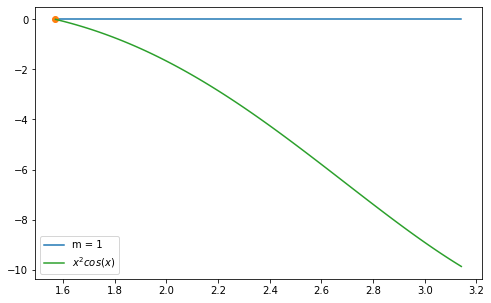

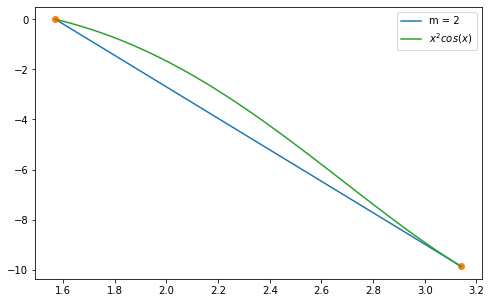

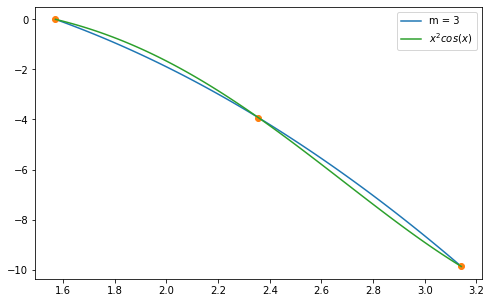

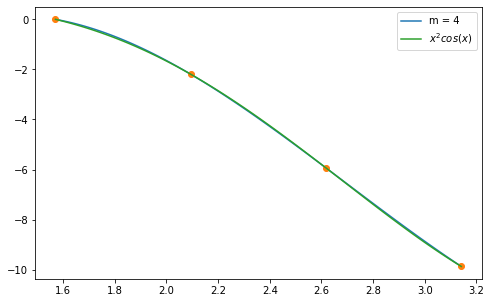

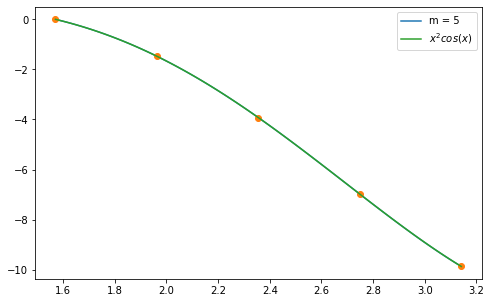

In [20]:
xxx = np.linspace(x1, x2, 100)
for m in range(1,6):
    plt.figure(figsize=(8,5))
    plot_P(np.linspace(x1, x2, m), f)
    plt.plot(xxx, f(xxx), label = "$x^2 cos(x)$")
    plt.legend()
    plt.show()

### II.2. 

Repeat the previous task using the Chebyshev nodes. Compare the quality of interpolation on a uniform mesh and Chebyshev nodes for $m=3$.

(20% of the total grade)

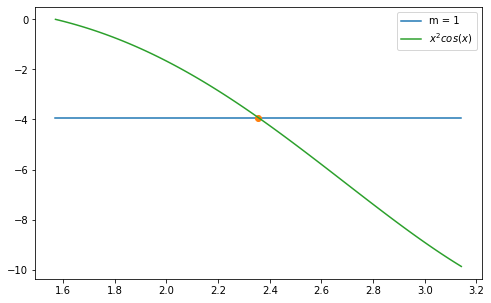

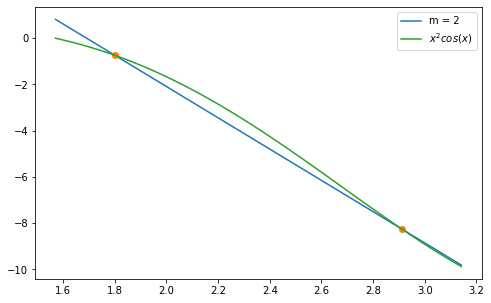

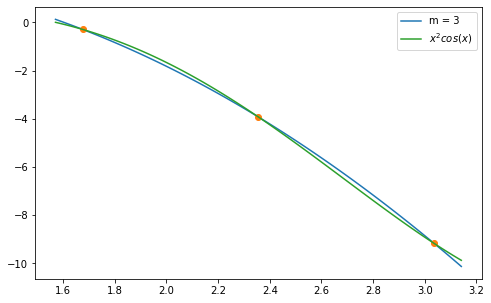

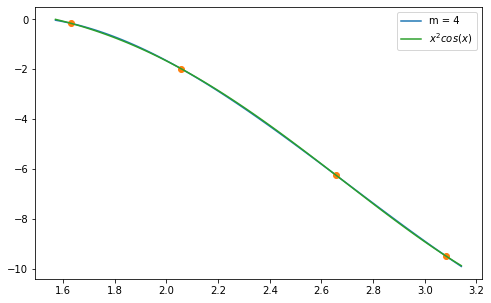

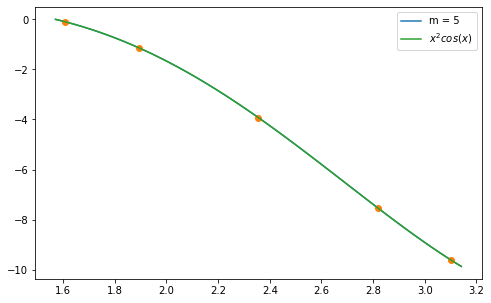

In [21]:
for m in range(1,6):
    plt.figure(figsize=(8, 5))
    x_cheb = (x1+x2)/2 + (x1-x2)*np.cos((2*np.arange(1,m+1)-1)/2/m*np.pi)/2
    plot_P(x_cheb, f)
    plt.plot(xxx, f(xxx), label = "$x^2 cos(x)$")
    plt.legend()
    plt.show()